In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone

import warnings
warnings.filterwarnings("ignore")

In [99]:
data =pd.read_csv(r'C:\Users\hornt\Documents\DS_Alma\03.Datasets\Ice Cream Sales.csv')
data.rename(columns={'Date':'Timestamp'},inplace =True)

print(data.shape)
print(data.head(2))

(60, 2)
    Timestamp       Sales
0  31-01-2018  118.476167
1  28-02-2018  140.641535


In [100]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'] )
data['Year'] =data['Timestamp'].dt.year
data['Month'] =data['Timestamp'].dt.month
data['Date'] =data['Timestamp'].dt.day
#data.drop('Timestamp',axis =1,inplace = True)
print(data.head(2))

   Timestamp       Sales  Year  Month  Date
0 2018-01-31  118.476167  2018      1    31
1 2018-02-28  140.641535  2018      2    28


In [101]:
print(data.describe())

                 Timestamp       Sales         Year      Month       Date
count                   60   60.000000    60.000000  60.000000  60.000000
mean   2020-07-15 12:00:00  105.502646  2020.000000   6.500000  30.433333
min    2018-01-31 00:00:00    0.064269  2018.000000   1.000000  28.000000
25%    2019-04-22 12:00:00   45.376818  2019.000000   3.750000  30.000000
50%    2020-07-15 12:00:00  110.131023  2020.000000   6.500000  31.000000
75%    2021-10-07 18:00:00  163.804822  2021.000000   9.250000  31.000000
max    2022-12-31 00:00:00  228.377989  2022.000000  12.000000  31.000000
std                    NaN   68.127616     1.426148   3.481184   0.830900


In [104]:
# Perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result_a = seasonal_decompose(data['Sales'], model='additive',period =30)
result_m = seasonal_decompose(data['Sales'], model='multiplicative',period =30)

Text(0.5, 0, 'Year')

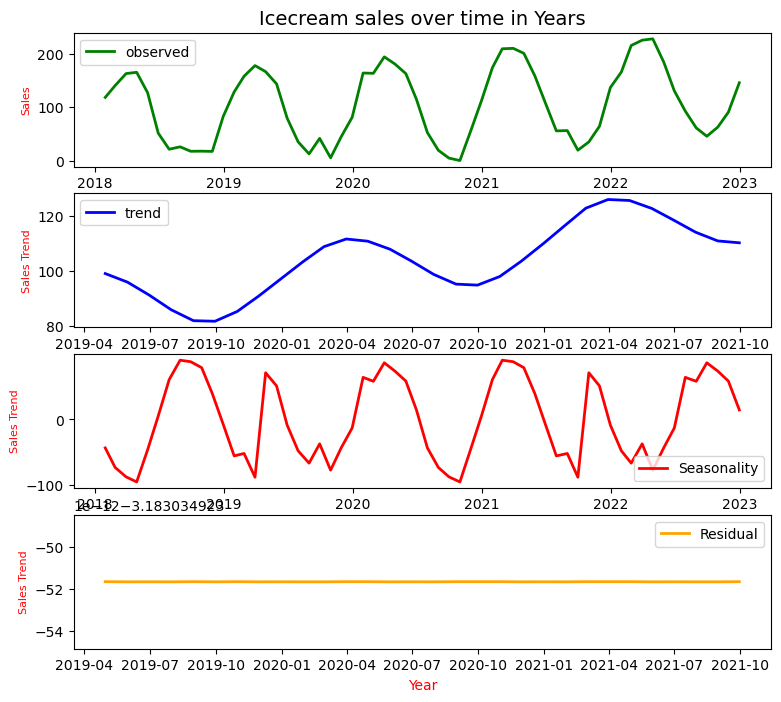

In [116]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(9, 8))
sns.lineplot(x=data['Timestamp'], y=data['Sales'], ax=ax[0], color='green',label ='observed',lw =2)
ax[0].set_title('Icecream sales over time in Years', fontsize=14)
ax[0].set_ylabel(ylabel='Sales', fontsize=8,color ='red')
ax[0].set_xlabel(xlabel ='Year')
#ax[0].set_xlim([date(2018, 1, 1), date(2023, 12, 31)])
#f.tight_layout()
#plt.subplots_adjust

sns.lineplot(x=data['Timestamp'], y=result_a.trend, ax=ax[1], color='blue',label ='trend',lw =2)
ax[1].set_ylabel(ylabel='Sales Trend', fontsize=8,color ='red')

sns.lineplot(x=data['Timestamp'], y=result_a.seasonal, ax=ax[2], color='red',label ='Seasonality',lw =2)
ax[2].set_ylabel(ylabel='Sales Trend', fontsize=8,color ='red')

sns.lineplot(x=data['Timestamp'], y=result_a.resid, ax=ax[3], color='orange',label ='Residual',lw =2)
ax[3].set_ylabel(ylabel='Sales Trend', fontsize=8,color ='red')
ax[3].set_xlabel(xlabel ='Year',color = 'red')

Original Sales Data: This plot shows the daily sales over the years. You can see the overall pattern with ups and downs.

Trend Component: This represents the general upward trend in sales throughout the year, reflecting the growing popularity of the shop.

Seasonality Component: This plot shows the seasonal pattern in the sales data, with peaks typically in the summer months and troughs in the winter, reflecting the expected seasonality in ice cream sales.

Residuals (Random Movements): This includes everything that can't be explained by the trend or seasonality. It represents the random variations in the sales data, which could be due to various unaccounted factors like weather changes, local events, or other random influences.

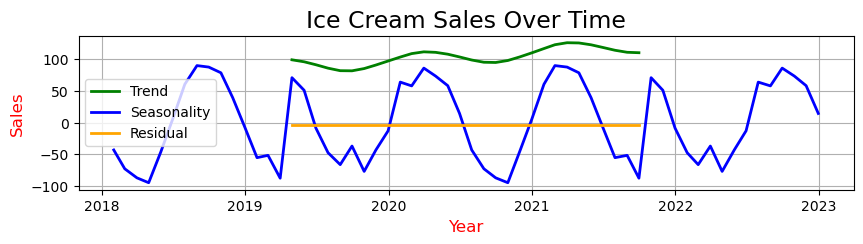

In [121]:
# Plotting the sales data

plt.figure(figsize=(10, 2))
plt.plot(data['Timestamp'],result_a.trend,color = 'green', lw =2,label ='Trend')
plt.plot(data['Timestamp'],result_a.seasonal,color = 'blue', lw =2,label ='Seasonality')
plt.plot(data['Timestamp'],result_a.resid,color = 'Orange', lw =2,label ='Residual')
plt.xlabel('Year',color ='red',fontsize =12)
plt.ylabel('Sales',color ='red',fontsize =12)
plt.title('Ice Cream Sales Over Time',fontsize = 17)
plt.legend()
plt.grid()
plt.show()

#### Tests for Stationarity

In [122]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test = adfuller(data['Sales'])
print("p-value of ADF test is", adf_test[1])

p-value of ADF test is 0.9884764789610927


The p-value of 0.9884 is much higher than the common significance levels (0.05 or 0.01), Hence, the series is non-stationary

#### Making a series Stationary

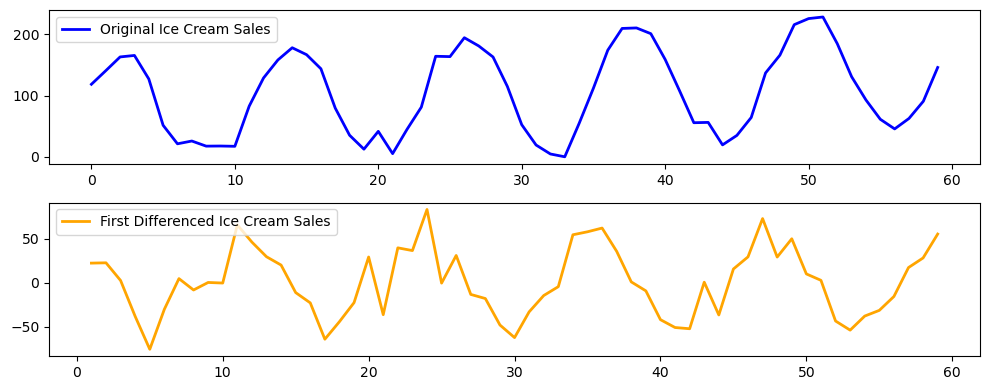

In [128]:
# Apply first differencing
data_diff = data['Sales'].diff().dropna()

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(data['Sales'], label='Original Ice Cream Sales',color ='blue',lw =2)
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(data_diff, label='First Differenced Ice Cream Sales', color='orange',lw =2)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [129]:
adf_test_first_diff = adfuller(sales_data_diff)
print("p-value of ADF test is", adf_test_first_diff[1])

p-value of ADF test is 7.362144448444294e-10


The p-value of is much lesser than the common significance levels (0.05 or 0.01), Hence, the series is stationary

#### Data Smoothening using Moving averages 

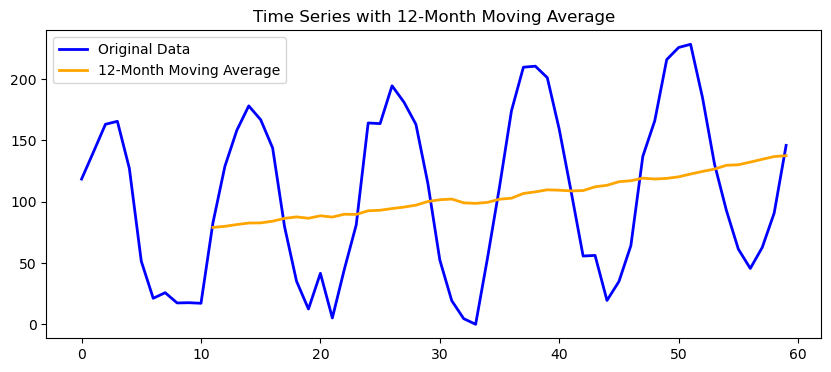

In [153]:
# Applying a moving average
moving_avg = data['Sales'].rolling(window=12).mean()  # 12 Month moving average

plt.figure(figsize=(10, 4))
plt.plot(data['Sales'], label='Original Data',color ='blue',lw =2)
plt.plot(moving_avg, label='12-Month Moving Average', color='orange',lw =2)
plt.legend(loc='upper left')
plt.title('Time Series with 12-Month Moving Average')
plt.show()

### ARIMA Model 

In [144]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Splitting the data into train and test sets
train = data['Sales'].iloc[:-10]  
test = data['Sales'].iloc[-10:]  

# ARIMA model 
arima_model = ARIMA(train, order=(7, 1, 7))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=10)

# Evaluating the models
arima_mse = mean_squared_error(test, arima_forecast)
arima_mse

250.65412792122305

### Plotting the model 

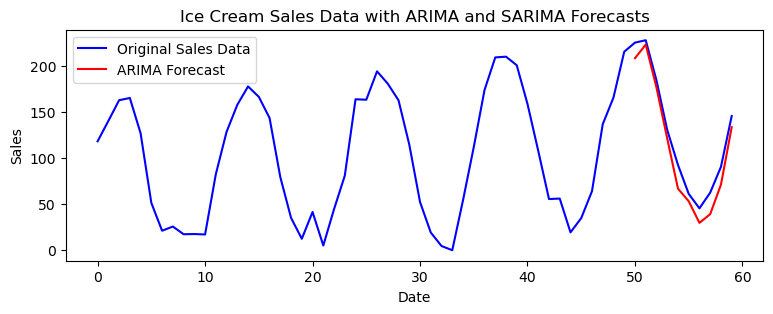

In [150]:
import matplotlib.pyplot as plt

# Re-plotting the forecasts along with the original data

plt.figure(figsize=(9, 3))
plt.plot(data['Sales'], label='Original Sales Data', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Ice Cream Sales Data with ARIMA and SARIMA Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()